In [ ]:

!pip install -q pycaret
!pip install -q catboost
!pip install --upgrade -q xgboost
!pip install haversine
!pip install reverse_geocoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.1 

# 1

In [ ]:
from pycaret.regression import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import  StandardScaler,MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import catboost
from scipy.stats import randint
from sklearn.metrics import mean_squared_log_error,silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, ExtraTreesRegressor
from haversine import haversine
from sklearn.datasets import fetch_california_housing as fch

# 데이터 로드

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/멋쟁이/9. 파이널프로젝트/회귀/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/멋쟁이/9. 파이널프로젝트/회귀/data/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/멋쟁이/9. 파이널프로젝트/회귀/data/sample_submission.csv')
sklearn_df = pd.DataFrame(fch()['data'], columns=fch()['feature_names'])
sklearn_df['MedHouseVal'] = fch()['target']
train["is_generated"] = True
test["is_generated"] = True
sklearn_df["is_generated"] = False
train_copy = pd.concat([train.drop('id',axis = 1),sklearn_df]).copy()

test_copy = test.copy().drop('id', axis=1)

train_copy.shape, test_copy.shape, submission.shape

((57777, 10), (24759, 9), (24759, 2))

In [ ]:
train.shape, sklearn_df.shape

((37137, 11), (20640, 10))

In [ ]:
X = train_copy.drop('MedHouseVal', axis = 1)
y = train_copy[['MedHouseVal']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

## 선형회귀 (LinearRegression)

### 모델 생성

In [ ]:
lr_model = LinearRegression() # 모델 생성
lr_model.fit(X_train, y_train) # 모델 학습
y_pred = lr_model.predict(X_test ) # 예측
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # 평가
print(rmse)
sub = lr_model.predict(test_copy)
submission['MedHouseVal'] = sub
submission.to_csv('LinearRegression_ori.csv',index = False)

0.721124487753399


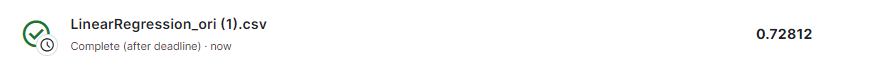

## 라쏘 (Lasso)

### 최적화 ( Lasso + gridsearchCV)

In [ ]:
lasso_model = Lasso()
param_grid = {
    'max_iter':[100,500,1000,2000,3000],
    'alpha':1/np.array([0.01,0.1,1,2,4,8,10,100,200,300]),
}
grid = GridSearchCV(lasso_model, param_grid = param_grid , cv = 5)
grid.fit(X_train, y_train)
print(grid.best_estimator_), print(grid.best_score_), print(grid.best_params_)

Lasso(alpha=0.0033333333333333335, max_iter=100)
0.5589014000412431
{'alpha': 0.0033333333333333335, 'max_iter': 100}


(None, None, None)

In [ ]:
sub = grid.best_estimator_.predict(test_copy)
submission['MedHouseVal'] = sub
submission.to_csv('Lasso.csv',index = False)

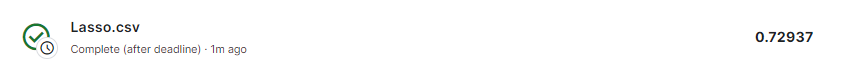

## 랜덤포레스트(RandomForestRegressor)

### 모델 생성

In [ ]:
rf_model = RandomForestRegressor(random_state = 42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)
sub = lr_model.predict(test_copy)
submission['MedHouseVal'] = sub
submission.to_csv('RandomForestRegressor_ori.csv',index = False)

0.5487350875290463


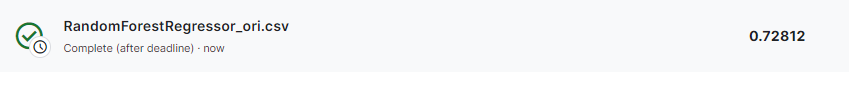

In [ ]:
pd.DataFrame(data = rf_model.feature_importances_.reshape((1,-1)), columns=X.columns)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,is_generated
0,0.53576,0.042521,0.049145,0.032291,0.03196,0.116637,0.088561,0.098443,0.004681


### 최적화 (GridSearchCV)

In [ ]:
params = {
    'n_estimators':[3, 10,  100],
    'max_depth' : [6, 8, 10, 12],
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}
rf_model = RandomForestRegressor(random_state = 42)
grid = GridSearchCV(rf_model, param_grid = params, cv = 5)
grid.fit(X_train, y_train)
print(grid.best_estimator_), print(grid.best_score_), print(grid.best_params_)
sub = grid.best_estimator_.predict(test_copy)
submission['MedHouseVal'] = sub
submission.to_csv('RandomForestRegressor_grid.csv',index = False)

RandomForestRegressor(max_depth=12, min_samples_leaf=8, min_samples_split=8,
                      random_state=42)
0.757050606116108
{'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}


## XGBoost

### 모델 생성

In [ ]:
xgb_model = xgb.XGBRegressor(random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)
sub = xgb_model.predict(test_copy)
submission['MedHouseVal'] = sub
submission.to_csv('XGBoost_ori.csv',index = False)

0.5349605631272787


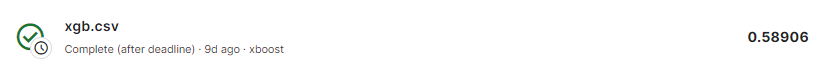

### 최적화 (GridSearchCV)

In [ ]:
xgb_model = xgb.XGBRegressor(random_state = 42)
param_grid={
    'n_estimators' : [100,200,300,400,500, 600],
    'learning_rate' : [0.01,0.05,0.1],
    'max_depth' : [2, 3, 4, 5]
    }
grid = GridSearchCV(xgb_model, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print(grid.best_estimator_), print(grid.best_score_), print(grid.best_params_)
sub = grid.best_estimator_.predict(test_copy)
submission['MedHouseVal'] = sub
submission.to_csv('XGBoost_grid.csv',index = False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
0.7911369820226607
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 600}


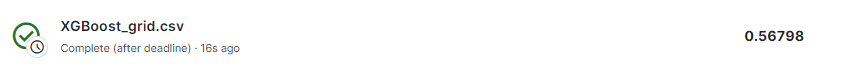

In [ ]:
pd.DataFrame(data = grid.best_estimator_.feature_importances_.reshape((1,-1)), columns=X.columns)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,is_generated
0,0.628515,0.032422,0.029781,0.011551,0.010582,0.11388,0.078659,0.092293,0.002318


## LightGBM

### 모델생성

In [ ]:
lgb_model = lgb.LGBMRegressor(random_state = 42)
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
sub = lgb_model.predict(test_copy)
submission['MedHouseVal'] = sub
submission.to_csv('Light_GBM_ori.csv',index = False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 46221, number of used features: 9
[LightGBM] [Info] Start training from score 2.075544
0.5293016716623686


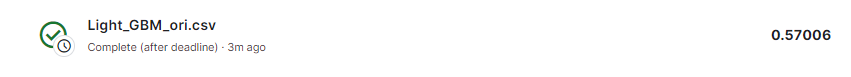

In [ ]:
pd.DataFrame(data = lgb_model.feature_importances_.reshape((1,-1)), columns=X.columns)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,is_generated
0,414,187,228,121,165,333,756,738,58


### 최적화 (GridSearchCV)

In [ ]:
param_grid = {"learning_rate" : [0.01,0.1,0.2,0.3,0.4,0.5],
             "max_depth" : [25, 50, 75],
             "num_leaves" : [100,300,500],
             "n_estimators" : [100, 200, 300,500],
              }
lgb_model = lgb.LGBMRegressor(random_state = 42)
grid = GridSearchCV(lgb_model, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print(grid.best_estimator_), print(grid.best_score_), print(grid.best_params_)
sub = grid.best_estimator_.predict(test_copy)
submission['MedHouseVal'] = sub
submission.to_csv('LightGBM_grid.csv',index = False)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 36976, number of used features: 9
[LightGBM] [Info] Start training from score 2.074978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 36977, number of used features: 9
[LightGBM] [Info] Start training from score 2.075092
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 36977, number of used features: 9
[LightGBM] [Info] Start training from score 2.075823
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003575 seconds.

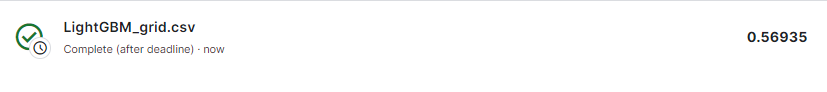

## CatBoost

### 모델생성

In [ ]:
cat_model = catboost.CatBoostRegressor(random_state = 42)
cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
sub = cat_model.predict(test_copy)
submission['MedHouseVal'] = sub
submission.to_csv('CatBoost_ori.csv',index = False)

Learning rate set to 0.075028
0:	learn: 1.1089580	total: 110ms	remaining: 1m 49s
1:	learn: 1.0657490	total: 160ms	remaining: 1m 19s
2:	learn: 1.0262197	total: 212ms	remaining: 1m 10s
3:	learn: 0.9907067	total: 260ms	remaining: 1m 4s
4:	learn: 0.9587810	total: 305ms	remaining: 1m
5:	learn: 0.9301378	total: 342ms	remaining: 56.7s
6:	learn: 0.9040139	total: 380ms	remaining: 53.9s
7:	learn: 0.8808693	total: 416ms	remaining: 51.6s
8:	learn: 0.8598801	total: 447ms	remaining: 49.2s
9:	learn: 0.8366366	total: 501ms	remaining: 49.6s
10:	learn: 0.8184421	total: 543ms	remaining: 48.8s
11:	learn: 0.8027236	total: 577ms	remaining: 47.5s
12:	learn: 0.7883195	total: 628ms	remaining: 47.7s
13:	learn: 0.7741216	total: 673ms	remaining: 47.4s
14:	learn: 0.7605988	total: 700ms	remaining: 46s
15:	learn: 0.7494224	total: 739ms	remaining: 45.4s
16:	learn: 0.7395021	total: 769ms	remaining: 44.4s
17:	learn: 0.7273152	total: 853ms	remaining: 46.5s
18:	learn: 0.7194106	total: 885ms	remaining: 45.7s
19:	learn: 0.

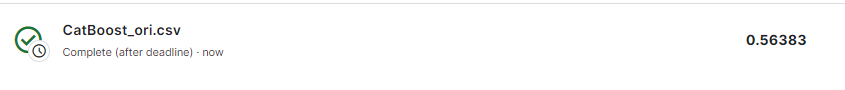

### 최적화 (GridSearchCV)

In [ ]:
cat_model = catboost.CatBoostRegressor(random_state = 42)
param_grid = {"depth" : [6,4,5,7,8,9,10],
          "iterations" : [250,100,500],
          "learning_rate" : [0.001,0.01,0.1,0.2,0.3],
          "l2_leaf_reg" : [2,5,10,20,30],
          "border_count" : [254]
          }
grid = GridSearchCV(cat_model, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print(grid.best_estimator_), print(grid.best_score_), print(grid.best_params_)
sub = grid.best_estimator_.predict(test_copy)
submission['MedHouseVal'] = sub
submission.to_csv('CatBoost_grid.csv',index = False)

## AUTO ML

In [ ]:
train1 = train_copy.copy().reset_index(drop = True)

In [ ]:
clf = setup(data      = train1,
            target    = 'MedHouseVal',
            verbose   = True,
            train_size= 0.9,
            data_split_shuffle=True,
            session_id= 100,
            normalize = True
            )

,Description,Value
0,Session id,100
1,Target,MedHouseVal
2,Target type,Regression
3,Original data shape,"(57777, 10)"
4,Transformed data shape,"(57777, 10)"
5,Transformed train set shape,"(51999, 10)"
6,Transformed test set shape,"(5778, 10)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [ ]:
top_5_model = compare_models(fold=5, round=3, sort="rmse", n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.361,0.274,0.523,0.796,0.157,0.201,10.700
lightgbm,Light Gradient Boosting Machine,0.373,0.287,0.535,0.786,0.161,0.209,3.208
xgboost,Extreme Gradient Boosting,0.373,0.290,0.539,0.783,0.162,0.208,1.412
rf,Random Forest Regressor,0.385,0.313,0.559,0.766,0.167,0.216,38.192
et,Extra Trees Regressor,0.388,0.316,0.562,0.764,0.167,0.215,14.010
gbr,Gradient Boosting Regressor,0.409,0.333,0.577,0.751,0.175,0.232,9.958
knn,K Neighbors Regressor,0.480,0.467,0.684,0.651,0.203,0.265,3.062
ridge,Ridge Regression,0.535,0.537,0.733,0.599,0.222,0.314,0.084
lr,Linear Regression,0.535,0.537,0.733,0.599,0.222,0.314,1.034
lar,Least Angle Regression,0.535,0.537,0.733,0.599,0.222,0.314,0.080


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

In [ ]:
top_5_model

 LGBMRegressor(n_jobs=-1, random_state=100),
 XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=100, ...),
 RandomForestRegressor(n_jobs=-1, random_state=100),
 ExtraTreesRegressor(n_jobs=-1, random_state=100)]

In [ ]:
tuning_model = tune_model(top_5_model[0],n_iter = 100, optimize = 'rmse')

- 대부분의 모델에서 AveBedrms 피처의 중요도가 낮다고 판단되어 삭제하고 진행

# 피처 삭제 후 진행

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/멋쟁이/9. 파이널프로젝트/회귀/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/멋쟁이/9. 파이널프로젝트/회귀/data/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/멋쟁이/9. 파이널프로젝트/회귀/data/sample_submission.csv')
sklearn_df = pd.DataFrame(fch()['data'], columns=fch()['feature_names'])
sklearn_df['MedHouseVal'] = fch()['target']
train["is_generated"] = True
test["is_generated"] = True
sklearn_df["is_generated"] = False
train_copy = pd.concat([train.drop(['id','AveBedrms'],axis = 1),sklearn_df.drop('AveBedrms',axis = 1)]).copy()

test_copy = test.copy().drop(['id','AveBedrms'], axis=1)

train_copy.shape, test_copy.shape, submission.shape

((57777, 9), (24759, 8), (24759, 2))

In [ ]:
X = train_copy.drop('MedHouseVal', axis = 1)
y = train_copy[['MedHouseVal']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

## 선형회귀

In [ ]:
lr_model = LinearRegression() # 모델 생성
lr_model.fit(X_train, y_train) # 모델 학습
y_pred = lr_model.predict(X_test ) # 예측
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # 평가
print(rmse)
sub = lr_model.predict(test_copy)
submission['MedHouseVal'] = sub
submission.to_csv('LinearRegression_ori_del.csv',index = False)

0.7335267302943626


In [ ]:
cat_model = catboost.CatBoostRegressor(random_state = 42)
cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
sub = cat_model.predict(test_copy)
submission['MedHouseVal'] = sub
submission.to_csv('CatBoost_ori_dek.csv',index = False)

Learning rate set to 0.075028
0:	learn: 1.1092523	total: 103ms	remaining: 1m 43s
1:	learn: 1.0662116	total: 199ms	remaining: 1m 39s
2:	learn: 1.0274607	total: 290ms	remaining: 1m 36s
3:	learn: 0.9918692	total: 378ms	remaining: 1m 34s
4:	learn: 0.9588696	total: 452ms	remaining: 1m 29s
5:	learn: 0.9293936	total: 519ms	remaining: 1m 26s
6:	learn: 0.9038525	total: 590ms	remaining: 1m 23s
7:	learn: 0.8806225	total: 649ms	remaining: 1m 20s
8:	learn: 0.8567644	total: 698ms	remaining: 1m 16s
9:	learn: 0.8361743	total: 752ms	remaining: 1m 14s
10:	learn: 0.8187141	total: 831ms	remaining: 1m 14s
11:	learn: 0.8032881	total: 876ms	remaining: 1m 12s
12:	learn: 0.7881608	total: 901ms	remaining: 1m 8s
13:	learn: 0.7749929	total: 929ms	remaining: 1m 5s
14:	learn: 0.7633298	total: 957ms	remaining: 1m 2s
15:	learn: 0.7524894	total: 984ms	remaining: 1m
16:	learn: 0.7431061	total: 1.02s	remaining: 59.1s
17:	learn: 0.7328573	total: 1.06s	remaining: 57.6s
18:	learn: 0.7221725	total: 1.09s	remaining: 56.5s
19

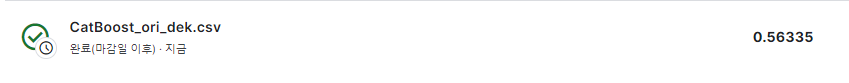

- 피처 제거 후 진행 시 0.0005정도 성능이 향상
- 크게 의미가 있다고 보이지는 않음